In [147]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, date
import matplotlib.ticker as mticker

# import csv file with timestamp in unix, daily closes
df = pd.read_csv('BITSTAMP_BTCUSD, 1D 2.csv')
df['time'] = df['time'].apply(lambda x: datetime.fromtimestamp(x))
df = df[(df['time'] >= datetime.fromisoformat('2019-01-01')) & (df['time'] <= datetime.fromisoformat('2023-05-31'))]

# take columns I am interested in
df = df[['time', 'open', 'high', 'low', 'close']]

# make a separate set of columns for OHLC data, shifted to yesterday's value (has to be done in order to conduct proper analysis)
df['prev_open'] = df['open'].shift(1)
df['prev_high'] = df['high'].shift(1)
df['prev_low'] = df['low'].shift(1)
df['prev_close'] = df['close'].shift(1)

# calculate daily pivot price
# dpp and other values for day 'n' are calculated with data from day 'n-1' to simulate data you have in real time trading
df['dpp'] = df[['prev_high','prev_low','prev_close']].sum(axis=1) / 3

# calculate second number
df['snr'] = df[['prev_high','prev_low']].sum(axis=1) / 2

# calculate abs dpr diff
df['dpr_dif'] = (df['dpp'] - df['snr']).abs()

df['dpr_low'] = df['dpp'] - df['dpr_dif']
df['dpr_high'] = df['dpp'] + df['dpr_dif']

# CALCULATIONS FOR 3DPR
# find 3 day low and high for each period
df['3d_low'] = df['prev_low'].rolling(window = 3).min()
df['3d_high'] = df['prev_high'].rolling(window = 3).max()

#  calculate 3 day pivot price
df['3dpp'] = df[['3d_high','3d_low','prev_close']].sum(axis=1) / 3

# calculate second number for 3dpr
df['snr_3dpr'] = df[['3d_high','3d_low']].sum(axis=1) / 2

# calculate abs dpr diff
df['3dpr_dif'] = (df['3dpp'] - df['snr_3dpr']).abs()

df['3dpr_low'] = df['3dpp'] - df['3dpr_dif']
df['3dpr_high'] = df['3dpp'] + df['3dpr_dif']



# make function 1, in which I check if today's open is above DPR
# if open is above DPR high i look for longs
# if open is below dpr low I look for shorts

def fn1(df):
    if ( df['open'] >= df['dpr_high'] ):
        return 'look_for_longs'
    elif (df['open'] <= df['dpr_low']):
        return 'look_for_shorts'

# add column trade opportunity with results from fn1
df['trade_opportunity'] = df.apply(fn1, axis = 1)

# function describes different trade types
def fn2(df):
    if (df['trade_opportunity'] == 'look_for_longs' and df['low'] <= df['dpr_high'] and df['low'] > df['dpr_low']):
        return 'perfect_long'
# perfect long not the best name, it means that long didn't get stoped out, it can be a profitable long or not
# perfect long is profitable when daily close is above DPR high and negative when close is between DPR low and DPR high 
    if (df['trade_opportunity'] == 'look_for_longs' and df['low']  <= df['dpr_low']):
        return 'stop_out_long'
    if (df['trade_opportunity'] == 'look_for_shorts' and df['high'] <= df['dpr_high'] and df['high'] > df['dpr_low']):
        return 'perfect_short'
# same definition as for long but the other way around
    if (df['trade_opportunity'] == 'look_for_shorts' and df['high'] >= df['dpr_high'] ):
        return 'stop_out_short'
    
df['ls'] = df.apply(fn2, axis = 1)

df_print = df[['open','low', 'high', 'close', 'dpp','dpr_low','dpr_high', '3dpp','3dpr_low','3dpr_high', 'trade_opportunity', 'ls']]
df_print.tail(20)

,open,low,high,close,dpp,dpr_low,dpr_high,3dpp,3dpr_low,3dpr_high,trade_opportunity,ls
2070,27624.0,26720.0,27640.0,26991.0,27596.000000,27585.000000,27607.000000,27709.000000,27663.500000,27754.500000,look_for_longs,stop_out_long
2071,26987.0,25800.0,27093.0,26811.0,27117.000000,27054.000000,27180.000000,27346.333333,27168.666667,27524.000000,look_for_shorts,perfect_short
2072,26816.0,26710.0,27052.0,26789.0,26568.000000,26446.500000,26689.500000,26979.666667,26895.333333,27064.000000,look_for_longs,None
2073,26805.0,26598.0,27202.0,26933.0,26850.333333,26819.666667,26881.000000,26743.000000,26720.000000,26766.000000,look_for_shorts,stop_out_short
2074,26933.0,26736.0,27666.0,27166.0,26911.000000,26900.000000,26922.000000,26645.000000,26501.000000,26789.000000,look_for_longs,stop_out_long
2075,27166.0,26868.0,27300.0,27037.0,27189.333333,27177.666667,27201.000000,27143.333333,27132.000000,27154.666667,look_for_shorts,stop_out_short
2076,27037.0,26550.0,27488.0,27404.0,27068.333333,27052.666667,27084.000000,27100.333333,27068.666667,27132.000000,look_for_shorts,stop_out_short
2077,27413.0,26374.0,27481.0,26818.0,27147.333333,27019.000000,27275.666667,27206.666667,27108.000000,27305.333333,look_for_longs,stop_out_long
2078,26824.0,26651.0,27176.0,26893.0,26891.000000,26854.500000,26927.500000,26893.333333,26855.666667,26931.000000,look_for_shorts,stop_out_short
2079,26889.0,26840.0,27153.0,27115.0,26906.666667,26899.833333,26913.500000,26918.333333,26905.666667,26931.000000,look_for_shorts,stop_out_short


In [148]:
print('perfect_long_count :')
print(df[df['ls'] == 'perfect_long'].count()['ls'])
print('stop_out_long_count :')
print(df[df['ls'] == 'stop_out_long'].count()['ls'])
print('perfect_short_count :')
print(df[df['ls'] == 'perfect_short'].count()['ls'])
print('stop_out_short_count :')
print(df[df['ls'] == 'stop_out_short'].count()['ls'])

perfect_long_count :
202
stop_out_long_count :
590
perfect_short_count :
141
stop_out_short_count :
491


In [149]:
# function calculates pct gain on trades
def fn4(df):
# the first condition checks if the trade was filled, so that means low has to be <= to dpr high where we have orders
# second part checks if low was above dpr low where we have stop orders
    if (df['trade_opportunity'] == 'look_for_longs' and df['low'] <= df['dpr_high'] and df['low'] >= df['dpr_low']) :
        return ((df['close'] - df['dpr_high']) / df['dpr_high']) *100
    if (df['trade_opportunity'] == 'look_for_longs' and df['low'] <= df['dpr_high'] and df['low'] < df['dpr_low']) :
        return ((df['dpr_low'] - df['dpr_high']) / df['dpr_high'] ) *100
# longs - vice versa
    if (df['trade_opportunity'] == 'look_for_shorts' and df['high'] >= df['dpr_low'] and df['high'] <= df['dpr_high']) :
        return (-((df['close'] - df['dpr_low']) / df['dpr_low'])) *100
    if (df['trade_opportunity'] == 'look_for_shorts' and df['high'] >= df['dpr_low'] and df['high'] > df['dpr_high']) :
        return (-(df['dpr_high'] - df['dpr_low']) / df['dpr_low'] ) *100

df['pct_on_trade'] = df.apply(fn4, axis = 1)

df_tbl1 = df
df_tbl1[['time','open','high','low','close', 'dpr_high','dpr_low','pct_on_trade','trade_opportunity']].tail(20)

,time,open,high,low,close,dpr_high,dpr_low,pct_on_trade,trade_opportunity
2070,2023-05-11 02:00:00,27624.0,27640.0,26720.0,26991.0,27607.000000,27585.000000,-0.079690,look_for_longs
2071,2023-05-12 02:00:00,26987.0,27093.0,25800.0,26811.0,27180.000000,27054.000000,0.898204,look_for_shorts
2072,2023-05-13 02:00:00,26816.0,27052.0,26710.0,26789.0,26689.500000,26446.500000,NaN,look_for_longs
2073,2023-05-14 02:00:00,26805.0,27202.0,26598.0,26933.0,26881.000000,26819.666667,-0.228688,look_for_shorts
2074,2023-05-15 02:00:00,26933.0,27666.0,26736.0,27166.0,26922.000000,26900.000000,-0.081718,look_for_longs
2075,2023-05-16 02:00:00,27166.0,27300.0,26868.0,27037.0,27201.000000,27177.666667,-0.085855,look_for_shorts
2076,2023-05-17 02:00:00,27037.0,27488.0,26550.0,27404.0,27084.000000,27052.666667,-0.115823,look_for_shorts
2077,2023-05-18 02:00:00,27413.0,27481.0,26374.0,26818.0,27275.666667,27019.000000,-0.941010,look_for_longs
2078,2023-05-19 02:00:00,26824.0,27176.0,26651.0,26893.0,26927.500000,26854.500000,-0.271835,look_for_shorts
2079,2023-05-20 02:00:00,26889.0,27153.0,26840.0,27115.0,26913.500000,26899.833333,-0.050806,look_for_shorts


This is visualization of May-23 trades

All of the trades are closed at close price (light green line)

Triangels stand for profitable longs and shorts, both are closed on the daily close - light green line 
 
x - are stoped out trades
 
Daily lows and highs are are added to give you idea about where in the range the trades occured


<Figure size 640x480 with 0 Axes>

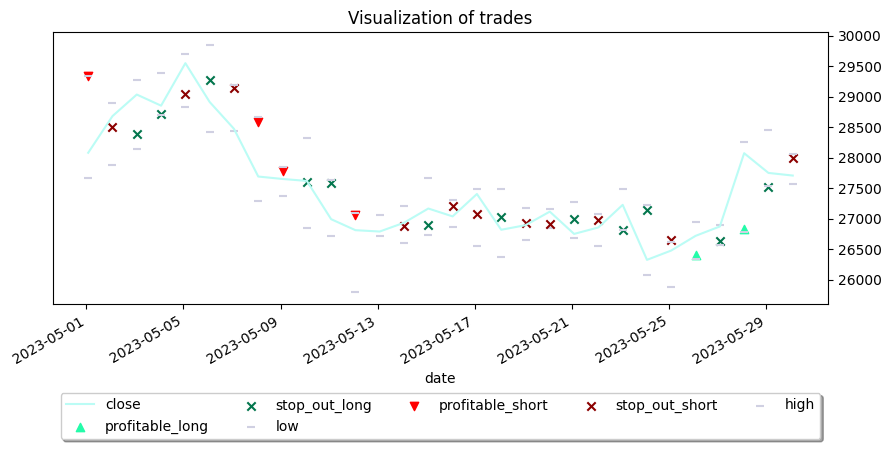

In [150]:
# function 5, checks for profitable longs and asigns entry to it
def fn5(df):
    if ((df['ls'] == 'perfect_long')& (df['close'] > df['dpr_high'])) :
        return df['dpr_high']

# function 6, checks for losses, stop outs and trades that closed within DPR (so close is below DPR high but not below dpr low)
def fn6(df):
    if ((df['ls'] == 'stop_out_long') | ((df['ls'] == 'perfect_long') & (df['close'] <= df['dpr_high']))):
        return df['dpr_low']

# function 7, checks for profitable shorts
def fn7(df):
    if ((df['ls'] == 'perfect_short') & (df['close'] < df['dpr_low'])):
        return df['dpr_low']
    

# function 8, checks for losses, stop outs and trades that closed within DPR (so close is above DPR low but not above dpr high)
def fn8(df):
    if ((df['ls'] == 'stop_out_short') | ((df['ls'] == 'perfect_short') & (df['close'] > df['dpr_low']))):
        return df['dpr_high']

        
df['in_money_long_entry'] = df.apply(fn5, axis = 1)
df['sl_triggered_long_sl'] = df.apply(fn6, axis = 1)
df['in_money_short_entry'] = df.apply(fn7, axis = 1)
df['sl_triggered_short_sl'] = df.apply(fn8, axis = 1)
        
df_plot = df
df_plot = df_plot[(df_plot['time'] >= datetime.fromisoformat('2023-05-01')) & (df_plot['time'] <= datetime.fromisoformat('2023-05-31'))]
 
    
x = df_plot['time']
y1 = df_plot['close']

y2 = df_plot['in_money_long_entry']
y3 = df_plot['sl_triggered_long_sl']
y4 = df_plot['low']
y5 = df_plot['in_money_short_entry']
y6 = df_plot['sl_triggered_short_sl']
y7 = df_plot['high']



fig = plt.figure()
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(x, y1, label='close', color = (187/255, 252/255, 226/235))
ax.scatter(x, y2, label='profitable_long', marker = "^", color =(36/255, 251/255, 169/255))
ax.scatter(x, y3, label='stop_out_long',  marker = "x", color =(3/255, 118/255, 71/235)) 
#ax.scatter(x, y4, label='low',  marker = "_", color =(208/255, 208/255, 208/235))  

ax.scatter(x, y4, label='low',  marker = "_", color =(208/255, 208/255, 208/235))  

ax.scatter(x, y5, label='profitable_short', marker = "v", color =(255/255, 0/255, 0/255))
ax.scatter(x, y6, label='stop_out_short',  marker = "x", color =(139/255, 0/255, 0/235)) 
ax.scatter(x, y7, label='high',  marker = "_", color =(208/255, 208/255, 208/235)) 

ax.set_xlabel('date')
ax.xaxis_date()

fig.autofmt_xdate()

ticks_loc = ax.get_yticks().tolist();

#x.set_yticklabels([f'{x:.0f}%' for x in ticks_loc]);
ax.yaxis.tick_right()
#ax.legend()
ax.set_title('Visualization of trades')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=5)

print('This is visualization of May-23 trades\n' '\nAll of the trades are closed at close price (light green line)' \
      '\n' '\nTriangels stand for profitable longs and shorts, both are closed on the daily close - light green line '\
      '\n ' '\nx - are stoped out trades'\
      '\n ' '\nDaily lows and highs are are added to give you idea about where in the range the trades occured')

In [151]:
# check how much we'd make
investment = x = 1000

df['running_sum'] = (1 + (df['pct_on_trade'] /100)).cumprod() * x


df['pct_change_hodl'] = df['close'].pct_change()
df['running_sum_hodl'] = (1 + (df['pct_change_hodl'])).cumprod() * x

df.head()


,time,open,high,low,close,prev_open,prev_high,prev_low,prev_close,dpp,...,trade_opportunity,ls,pct_on_trade,in_money_long_entry,sl_triggered_long_sl,in_money_short_entry,sl_triggered_short_sl,running_sum,pct_change_hodl,running_sum_hodl
479,2019-01-01 01:00:00,3693.85,3845.46,3629.66,3823.44,NaN,NaN,NaN,NaN,0.000000,...,look_for_longs,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
480,2019-01-02 01:00:00,3825.41,3918.67,3770.00,3885.87,3693.85,3845.46,3629.66,3823.44,3766.186667,...,look_for_longs,perfect_long,2.399503,3794.813333,NaN,NaN,NaN,1023.995032,0.016328,1016.328228
481,2019-01-03 01:00:00,3890.27,3893.40,3760.00,3787.81,3825.41,3918.67,3770.00,3885.87,3858.180000,...,look_for_longs,stop_out_long,-0.715130,NaN,3844.335,NaN,NaN,1016.672139,-0.025235,990.681167
482,2019-01-04 01:00:00,3785.64,3850.33,3732.38,3817.71,3890.27,3893.40,3760.00,3787.81,3813.736667,...,look_for_shorts,stop_out_short,-0.682142,NaN,NaN,NaN,3826.7,1009.736993,0.007894,998.501350
483,2019-01-05 01:00:00,3822.00,3887.09,3780.00,3791.84,3785.64,3850.33,3732.38,3817.71,3800.140000,...,look_for_longs,stop_out_long,-0.461285,NaN,3791.355,NaN,NaN,1005.079228,-0.006776,991.735191


Text(0.5, 1.0, 'Portfolio performance')

<Figure size 640x480 with 0 Axes>

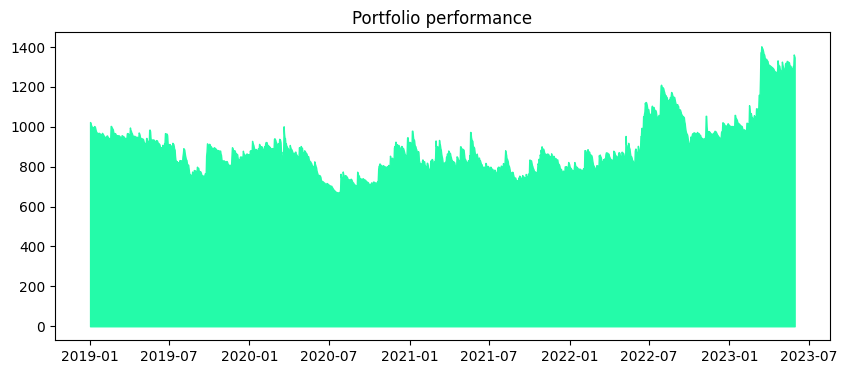

In [152]:
df_plot2 = df
# df_plot2 = df_plot2[(df_plot2['time'] >= datetime.fromisoformat('2021-01-01')) & (df_plot2['time'] <= datetime.fromisoformat('2023-05-31'))]
 
    
x = df_plot2['time']
y1 = df_plot2['running_sum'].ffill()


fig = plt.figure()
fig, ax = plt.subplots(figsize=(10,4))

ax.fill_between(x, y1, label='close', color = (36/255, 251/255, 169/255))
ax.set_title('Portfolio performance')

Text(0.5, 1.0, 'Portfolio performance vs hodl')

<Figure size 640x480 with 0 Axes>

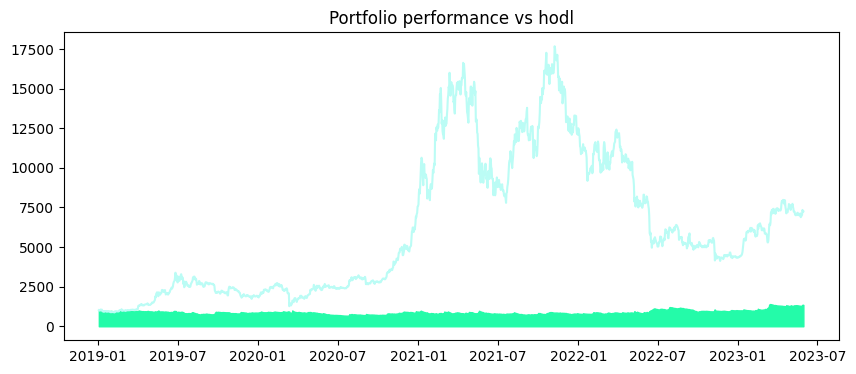

In [153]:
# this is how it looks vs hodl

    
x = df_plot2['time']
y1 = df_plot2['running_sum'].ffill()
y2 = df_plot2['running_sum_hodl'].ffill()

fig = plt.figure()
fig, ax = plt.subplots(figsize=(10,4))

ax.fill_between(x, y1, label='close', color = (36/255, 251/255, 169/255))
ax.plot(x, y2, label='close', color = (187/255, 252/255, 226/235))
ax.set_title('Portfolio performance vs hodl')

In [154]:
average_gain = df.loc[df['pct_on_trade'] > 0, 'pct_on_trade'].mean().round(2)
average_loss = df.loc[df['pct_on_trade'] < 0, 'pct_on_trade'].mean().round(2)

max_gain = df.loc[df['pct_on_trade'] > 0, 'pct_on_trade'].max().round(2)
max_loss = df.loc[df['pct_on_trade'] < 0, 'pct_on_trade'].min().round(2)

count_gain = df.loc[df['pct_on_trade'] > 0, 'pct_on_trade'].count()
count_loss = df.loc[df['pct_on_trade'] < 0, 'pct_on_trade'].count()

print(count_gain,' count gain')
print(average_gain,' average pct gain')
print(max_gain,' max pct gain')
print(' ')
print(count_loss,' count loss')
print(average_loss,' average pct loss')
print(max_loss,' max pct loss')


284  count gain
2.85  average pct gain
15.58  max pct gain
 
1139  count loss
-0.66  average pct loss
-5.05  max pct loss


In [155]:
df['dpr_range'] = df['dpr_high'] / df['dpr_low'] - 1 
loosest_range = df.loc[df['dpr_range'] > 0, 'dpr_range'].max().round(2)
# 0.19 apparently
date = df.loc[df['dpr_range'] > 0.1, ['time']]

widest_range = df['dpr_range'].max().round(4)
tightest_range = df['dpr_range'].min()
avg_range = df['dpr_range'].mean().round(4)

print('multiply by 100 if you want pct')
print('')
print('loosest range: ',loosest_range)
print('tightest_range: ',tightest_range)
print('avg_range: ',avg_range)
print('')
# big range
print('date of 19 pct range')
print(' ')
print(date)

multiply by 100 if you want pct

loosest range:  0.19
tightest_range:  0.0
avg_range:  0.009

date of 19 pct range
 
                   time
916 2020-03-13 01:00:00


In [180]:
# check performace of trades in different ranges
import seaborn as sns


df['pct_on_trade1'] = df['pct_on_trade'].dropna()
# function x, checks for profitable trades
def fnx(df):
    if df['pct_on_trade1'] > 0.5:
        return 1.0
    else:
        return 0

# fn y
def fny(df):
    if df['dpr_range'] <= 0:
        return 0
    else:
        return df['dpr_range']

df['positive_trades'] = df.apply(fnx, axis = 1)
df['positive_trades'].astype(float)
df['dpr_range1'] = df.apply(fny, axis = 1).abs()

num_bins = 20  # Number of bins you want

df['range_bins'] = pd.cut(df['dpr_range1'], bins=num_bins)

df['average_value'] = df.groupby('range_bins')['dpr_range'].transform('mean')


df_sum = df.groupby('average_value')['positive_trades'].sum()

print('The left column represents avg width of the range in which trade entry occured'\
      '\n''\nRight column represents count of trades that made +0.5% of profit'\
      '\n''\ni.e. 97 trades that profited >0.5% occured in 0,41% tight range')


df_sum



The left column represents avg width of the range in which trade entry occured

Right column represents count of trades that made +0.5% of profit

i.e. 97 trades that profited >0.5% occured in 0,41% tight range


average_value
0.004061     97.0
0.013573    104.0
0.023002     30.0
0.033614      8.0
0.042003      5.0
0.052945      2.0
0.063470      1.0
0.095195      0.0
0.190772      0.0
Name: positive_trades, dtype: float64

In [181]:
# check performace of trades in different ranges
import seaborn as sns


df['pct_on_trade1'] = df['pct_on_trade'].dropna()
# function x, checks for profitable trades
def fnx(df):
    if df['pct_on_trade1'] > 5.5:
        return 1.0
    else:
        return 0

# fn y
def fny(df):
    if df['dpr_range'] <= 0:
        return 0
    else:
        return df['dpr_range']

df['positive_trades1'] = df.apply(fnx, axis = 1)
df['positive_trades1'].astype(float)
df['dpr_range1'] = df.apply(fny, axis = 1).abs()

num_bins = 20  # Number of bins you want
df['range_bins'] = pd.cut(df['dpr_range1'], bins=num_bins)
df['average_value'] = df.groupby('range_bins')['dpr_range'].transform('mean')
df_sum1 = df.groupby('average_value')['positive_trades1'].sum()

print('The left column represents avg width of the range in which trade entry occured'\
      '\n''\nRight column represents count of trades that made +5.5% of profit'\
      '\n''\ni.e. 20 trades that profited >5.5% occured in 0,41% tight range')
df_sum1

The left column represents avg width of the range in which trade entry occured

Right column represents count of trades that made +5.5% of profit

i.e. 20 trades that profited >5.5% occured in 0,41% tight range


average_value
0.004061    20.0
0.013573    15.0
0.023002     4.0
0.033614     1.0
0.042003     0.0
0.052945     0.0
0.063470     0.0
0.095195     0.0
0.190772     0.0
Name: positive_trades1, dtype: float64